In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

from modules.spectral_pool import spectral_pool, max_pool, l2_loss_images
from modules.frequency_dropout import test_frequency_dropout
from modules.create_images import open_image, downscale_image
from modules.utils import load_cifar10

np.set_printoptions(precision=3, linewidth=200)

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
images, _ = load_cifar10(1, get_test_data=False)
images.shape

file already downloaded..
getting batch 1


### In the cell below, we choose two random images and show how the quality progressively degradees as frequency dropout is applied.

Cutoff = 16


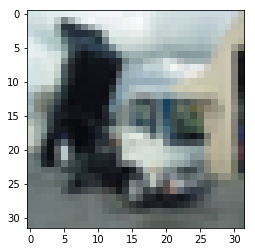

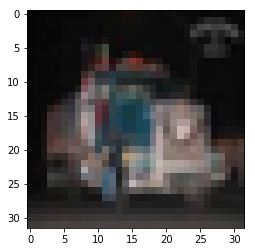

Cutoff = 14


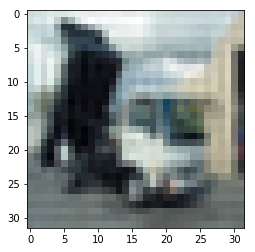

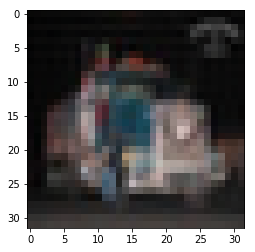

Cutoff = 12


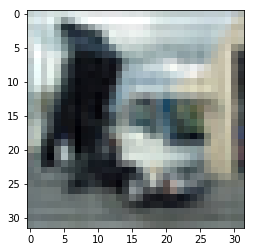

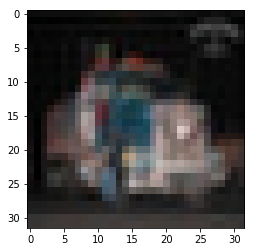

Cutoff = 10


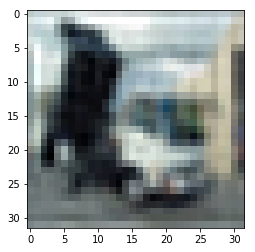

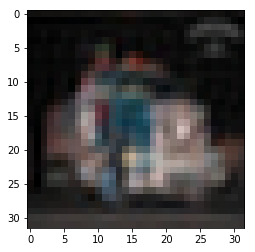

Cutoff = 8


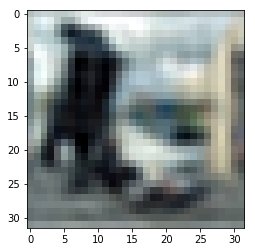

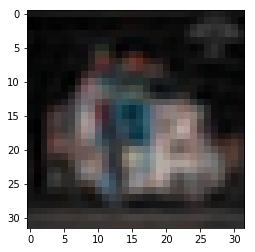

Cutoff = 6


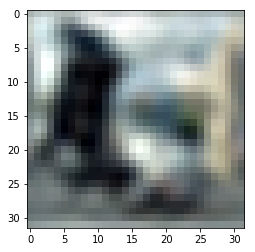

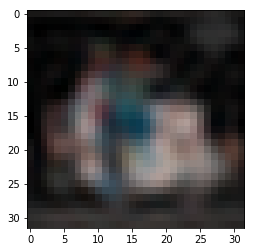

Cutoff = 4


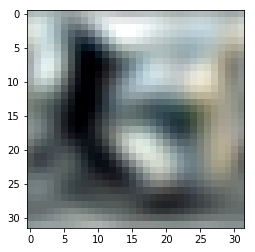

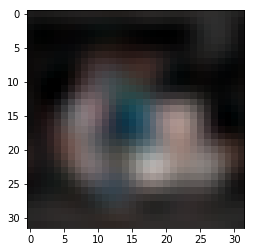

Cutoff = 2


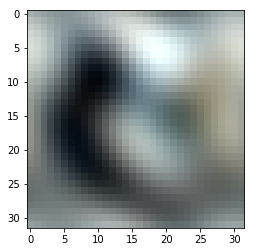

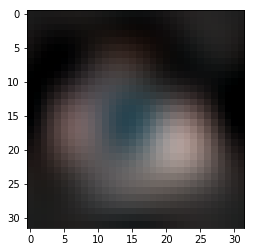

In [9]:
batch_size=2
random_selection_indices = np.random.choice(len(images), size=batch_size)

for cutoff in range(16,1,-2):
    minibatch_cutoff = tf.cast(tf.constant(cutoff), dtype=tf.float32)
    random_selection = images[random_selection_indices]
    downsampled_images = np.moveaxis(
        test_frequency_dropout(
            np.moveaxis(random_selection, 3, 1),
            minibatch_cutoff
        ), 1, 3
    )
    print('Cutoff = {0}'.format(cutoff))
    for i in range(batch_size):
        plt.imshow(np.clip(downsampled_images[i],0,1), cmap='gray')
        plt.show()

### The next cell demonstrates how the random cutoff is applied to all images in a minibatch, but changes from batch to batch.

Minibatch 1


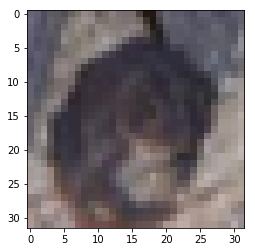

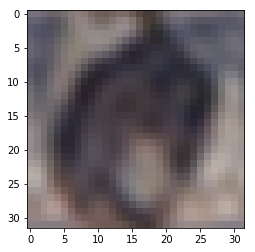

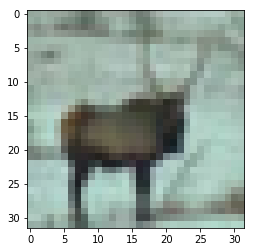

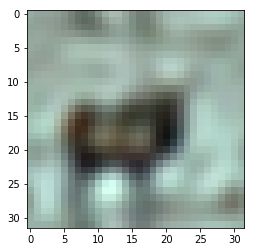

Minibatch 2


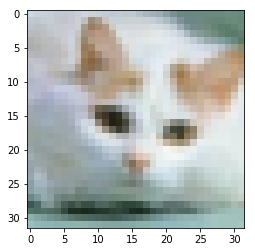

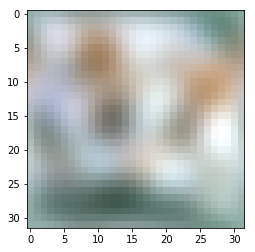

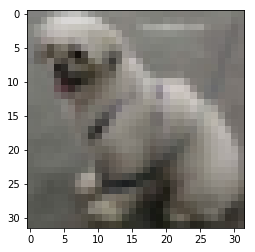

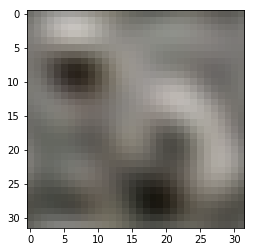

Minibatch 3


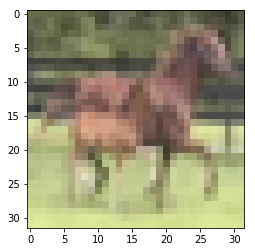

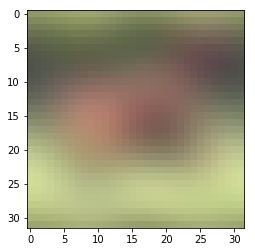

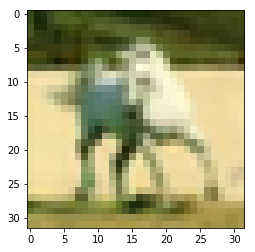

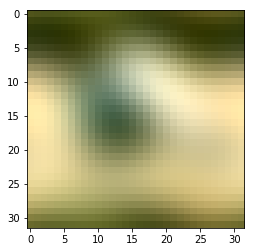

In [7]:
batch_size = 2
minibatch_cutoff = tf.random_uniform([], 2, 12)

for iter_idx in range(3):
    random_selection_indices = np.random.choice(len(images), size=batch_size)
    random_selection = images[random_selection_indices]
    downsampled_images = np.moveaxis(
        test_frequency_dropout(
            np.moveaxis(random_selection, 3, 1),
            minibatch_cutoff
        ), 1, 3
    )
    print('Minibatch {0}'.format(iter_idx+1))
    for i in range(batch_size):
        plt.imshow(random_selection[i], cmap='gray')
        plt.show()
        plt.imshow(np.clip(downsampled_images[i],0,1), cmap='gray')
        plt.show()

### max pool test

In [5]:
images_pool = max_pool(images, 2)
images_pool.shape

(10000, 32, 32, 3)

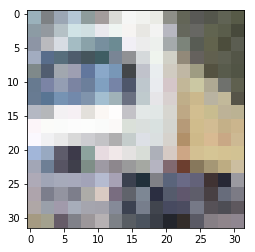

In [6]:
plt.imshow(images_pool[1], cmap='gray')

### spectral pool test

In [7]:
images.shape

(10000, 32, 32, 3)

In [5]:
images_moved = np.moveaxis(images, -1, 1)

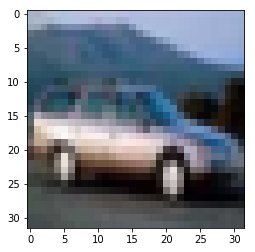

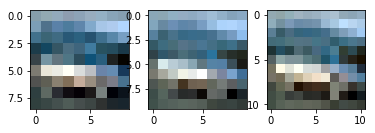

In [55]:
image_idx = 4
test_freq = 10

plt.imshow(images[image_idx])
plt.show()
fig, axes = plt.subplots(1,3)
for trunc_freq, ax in zip([test_freq-1,test_freq,test_freq+1], axes.ravel()):
    images_pooled, images_sp = spectral_pool(images_moved[image_idx:(image_idx+1)], trunc_freq, return_transformed=True)
    ax.imshow(np.clip(images_sp[0],0,1), cmap='gray')
plt.show()

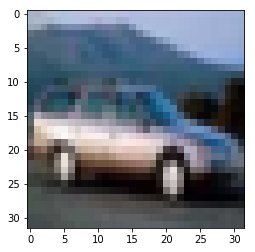

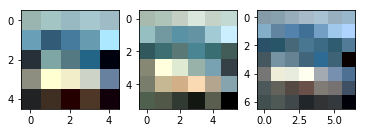

In [37]:
image_idx = 4
test_freq = 6

plt.imshow(images[image_idx])
plt.show()
fig, axes = plt.subplots(1,3)
for trunc_freq, ax in zip([test_freq-1,test_freq,test_freq+1], axes.ravel()):
    images_pooled, images_sp = spectral_pool(images_moved[image_idx:(image_idx+1)], trunc_freq, return_transformed=True)
    ax.imshow(np.clip(images_sp[0],0,1), cmap='gray')
plt.show()

## Iterate and plot

In [ ]:
# calculate losses for max_pool:
pool_size_mp = [2, 4, 8, 16, 32]
max_pool_errors = []
for s in pool_size_mp:
    images_pool = max_pool(images, s)
    loss = l2_loss_images(images, images_pool)
    max_pool_errors.append(loss)

In [ ]:
# calculate losses for spectral_pool:
# takes a long time to run, could be optimized but not high priority
filter_size_sp = np.arange(1, 32, 2)
spec_pool_errors = []
for s in filter_size_sp:
    images_sp = spectral_pool(images, s)[0]
    loss = l2_loss_images(images, images_sp)
    spec_pool_errors.append(loss)

In [ ]:
pool_frac_kept = [1/x**2 for x in pool_size_mp]
sp_frac_kept = [(x/32.)**2 for x in filter_size_sp]

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(pool_frac_kept, max_pool_errors, basey=2,
            marker='o', linestyle='--', color='r', label='Max Pooling')
ax.semilogy(sp_frac_kept, spec_pool_errors, basey=2,
            marker='o', linestyle='--', color='b', label='Spectral Pooling')
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel('Fraction of Parameters Kept')
ax.set_ylabel('Relative Loss')